In [1]:
from datetime import date
from glob import glob
import json
import math
import os
import sys
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import integrate, interpolate, stats

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_events_wdict
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

#### Load excel sheet with metadata for experiments

In [5]:
_gc = gspread.service_account() # need a key file to access the account
## Load Templeton log ##
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
Temp_metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe
## Load Zap&zip log ##
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
ZZ_metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

In [6]:
plotdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\brain_states_analyses\EP metrics'

### Load subjects .csv

In [7]:
multisub_file = r"C:\Users\lesliec\OneDrive - Allen Institute\data\brain_states_subjects_2024_06.csv"
subject_df = pd.read_csv(multisub_file, converters={'mouse': str}).astype({'analyze_EEG': bool, 'analyze_NPX': bool})

In [8]:
subject_df.head()

,exp_type,mouse,experiment,sweep_states,bad_chs,analyze_EEG,analyze_NPX,CCF_res,notes
0,urethane,582386,urethane_2021-07-15_11-36-58,urethane,"0,2,3",True,True,10,NaN
1,urethane,638703,urethane_estim_2022-10-14_12-25-20,urethane,"0,3,4,6,7,11,13",True,True,25,NaN
2,urethane,654181,urethane_vis_2022-11-23_08-30-16,urethane,"7,8,11,13",True,True,25,NaN
3,urethane,654182,urethane_vis_2022-12-02_11-02-25,urethane,"3,6,14,22,23",True,True,25,NaN
4,urethane,631037,urethane_2022-12-07_10-34-51,urethane,"6,7,8,21",True,True,25,NaN


### Multi-subject loop

#### Get EEG traces for all states/estim

In [9]:
StimType = 'biphasic'

inj_window = 90 * 60 # min to include as "psilocybin" -> seconds

trial_threshold = 20 # must have more than this number of trials to be included in analysis
trial_max = 100 # limit some states that have many trials

In [10]:
allsubs = np.unique(subject_df.mouse.values)

all_info = {}
for mousei in allsubs:
    print(mousei)
    mouse_df = subject_df[subject_df['mouse'] == mousei]
    
    if not any(mouse_df.analyze_EEG.values):
        print(' Not analyzing the experiments for this subject./n')
        continue
        
    all_info[mousei] = {}

    for dfind, subrow in mouse_df.iterrows():
        print(' {}'.format(subrow.experiment))
        if not subrow.analyze_EEG:
            print('  Not analyzing this experiment: "analyze"=False.')
            continue
        if subrow.bad_chs == 'all':
            print('  Not analyzing this experiment: bad EEG.')
            continue
        all_info[mousei][subrow.exp_type] = {'info': {}, 'EEG_traces': {}}
        data_loc = os.path.join('F:\psi_exp', 'mouse' + mousei, subrow['experiment'], 'experiment1', 'recording1')
        subexp = EEGexp(data_loc, preprocess=False, make_stim_csv=False)

        ## Grab exp metadata from Templeton-log_exp ##
        if np.any([True if subrow.mouse in x else False for x in np.unique(Temp_metadata['mouse_name'].values)]):
            exp_meta = Temp_metadata[(
                (Temp_metadata['mouse_name'].str.contains(subrow.mouse)) & (Temp_metadata['exp_name'].str.contains(subrow.experiment))
            )].squeeze()
        elif np.any([True if subrow.mouse in x else False for x in np.unique(ZZ_metadata['mouse_name'].values)]):
            exp_meta = ZZ_metadata[(
                (ZZ_metadata['mouse_name'].str.contains(subrow.mouse)) & (ZZ_metadata['exp_name'].str.contains(subrow.experiment))
            )].squeeze()
        else:
            print('Cannot find {}: {} in the experiment log excel sheets.'.format(subrow.mouse, subrow.experiment))

        ## Get injection times ##
        if subrow.exp_type in ['psilocybin', 'ketanserin']:
            inj_times = [float(exp_meta['First injection time (s)']), float(exp_meta['Second injection time (s)'])]
        else:
            print('  This {} experiment has no injection times.'.format(subrow.exp_type))
            inj_times = None

        ## Load stim log and apply sweep labels ##
        stim_log = pd.read_csv(subexp.stimulus_log_file).astype({'parameter': str})
        ### Get state label for each sweep ###
        all_sweeps = np.unique(stim_log['sweep'].values)
        sweep_state_list = []
        for char in subrow.sweep_states.split(','):
            sweep_state_list.append(char)
        if len(sweep_state_list) == 1:
            sweep_state_list = sweep_state_list * len(all_sweeps)
        stim_log['state'] = stim_log.apply(lambda x: sweep_state_list[x.sweep], axis=1)
        ### Get list of states and the middle current ###
        states = np.unique(stim_log['state'].values)
        currents = np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values).astype(int)
        if len(currents) > 1:
            estim_current = {x: str(y) for x, y in zip(['low', 'mid', 'high'], currents)}
        else:
            estim_current = {'mid': str(currents[0])}

        ## Get bad EEG channels ##
        badchstr = subrow.bad_chs.replace(' ','')
        bad_chs = []
        for char in badchstr.split(','):
            if char.isdecimal():
                bad_chs.append(int(char))

        ## Load EEG traces ##
        all_EEG_traces = np.load(os.path.join(subexp.data_folder, 'evoked_data', 'event_EEGtraces.npy'))
        EEG_event_timestamps = np.load(os.path.join(subexp.data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
        eeg_chs = np.arange(0, all_EEG_traces.shape[1])
        GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
        all_info[mousei][subrow.exp_type]['info']['good_chs'] = GOOD_CHS

        ## Get event traces ##
        estimlog = stim_log[stim_log['stim_type'] == StimType]
        for statei in states:
            all_info[mousei][subrow.exp_type]['EEG_traces'][statei] = {}

            for clevel, parami in estim_current.items():
                eventdf = get_events_wdict(
                    estimlog, {'state': statei, 'parameter': parami, 'good': True, 'resting_trial': True}, out='df')
                ## Add injection times ##
                if statei in ['psilocybin', 'ketanserin']:
                    eventdf['onset_from_inj'] = eventdf['onset'] - inj_times[1]
                    event_inds = eventdf[eventdf['onset_from_inj'] < inj_window].index.values
                else:
                    event_inds = eventdf.index.values
                if len(event_inds) < trial_threshold:
                    continue
                elif len(event_inds) > trial_max:
                    event_inds = np.random.choice(event_inds, size=trial_max, replace=False)
                event_traces = all_EEG_traces[:, :, event_inds]
                ## Apply common average reference ##
                event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                all_info[mousei][subrow.exp_type]['EEG_traces'][statei][clevel] = [EEG_event_timestamps, event_traces]

    print('')

582386
 urethane_2021-07-15_11-36-58
Experiment type: electrical stimulation
  This urethane experiment has no injection times.

631037
 urethane_2022-12-07_10-34-51
Experiment type: electrical stimulation
  This urethane experiment has no injection times.

638703
 urethane_estim_2022-10-14_12-25-20
Experiment type: electrical stimulation
  This urethane experiment has no injection times.

654181
 urethane_vis_2022-11-23_08-30-16
Experiment type: electrical and sensory stimulation
  This urethane experiment has no injection times.

654182
 urethane_vis_2022-12-02_11-02-25
Experiment type: electrical and sensory stimulation
  This urethane experiment has no injection times.

655955
 Not analyzing the experiments for this subject./n
655956
 urethane_2022-12-16_10-45-18
Experiment type: electrical stimulation
  This urethane experiment has no injection times.

666193
 Not analyzing the experiments for this subject./n
666194
 Not analyzing the experiments for this subject./n
666196
 Not an

## EP metrics

In [12]:
PCI_params = {
    'baseline_window': (-0.8, -0.002), # s before stim for baseline, my default: (-0.5, -0.001)
    'response_window': (0.002, 0.8), # s after stim for response, my default: (0.001, 0.5)
    'k': 1.2,
    'min_snr': 1.6, # my default: 1.1
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}
zlim = 3
comp_dict = {'first': [0.002, 0.025], 'early': [0.003, 0.05], 'late': [0.15, 0.25]}

In [13]:
EEG_sample_rate = 2500.

all_sub_metrics = []
for mousei in all_info.keys():
    print(mousei)
    for expi in all_info[mousei].keys():
        print(' {}'.format(expi))
        good_chs = all_info[mousei][expi]['info']['good_chs']
        for statei in all_info[mousei][expi]['EEG_traces'].keys():
            print('  {}'.format(statei))
            for curri in all_info[mousei][expi]['EEG_traces'][statei].keys():
                
                timex = all_info[mousei][expi]['EEG_traces'][statei][curri][0]
                ep_trials = all_info[mousei][expi]['EEG_traces'][statei][curri][1]
                
                num_trials = ep_trials.shape[2]
                
                state_avg = np.mean(ep_trials, axis=2)

                ## Calculate global field power duration ##
                gfpow = np.std(state_avg[:, good_chs], axis=1)
                blmean = np.mean(gfpow[timex < 0])
                blstd = np.std(gfpow[timex < 0])
                zgfpow = (gfpow - blmean) / blstd
                response_duration = np.sum(zgfpow[timex > 0] > zlim) / EEG_sample_rate

                ## Area under global field power curve ##
                zerp = np.where((zgfpow[timex > 0] - zlim) >= 0, (zgfpow[timex > 0] - zlim), 0.)
                auc = integrate.simps(zerp, timex[timex > 0], axis=0, even='last')

                ## Calulate PCIst ##
                PCIval = calc_PCIst(state_avg[:, good_chs].T, timex, **PCI_params)
                
                ## Rectified amplitude ##
                rect_mean = np.mean(np.abs(state_avg[:, good_chs]), axis=1)
                amptemp = []
                for wini, windowi in comp_dict.items():
                    testinds = np.nonzero((EEG_event_timestamps >= windowi[0]) & (EEG_event_timestamps <= windowi[1]))[0]
                    amptemp.append(np.mean(rect_mean[testinds]))

                all_sub_metrics.append([
                    mousei, expi, len(good_chs), statei, curri, num_trials, amptemp[0], response_duration, auc, PCIval,
                    amptemp[1], amptemp[2]
                ])
                    
    print('')
    
EEG_metrics = pd.DataFrame(
    all_sub_metrics,
    columns=['mouse', 'experiment', 'num_good_chs', 'state', 'stim_current', 'num_trials', 'first_peak_amp',
             'response_duration', 'response_magnitude', 'PCIst', 'early_amp', 'late_amp'
            ]
)

582386
 urethane
  urethane

631037
 urethane
  urethane

638703
 urethane
  urethane

654181
 urethane
  urethane

654182
 urethane
  urethane

655956
 urethane
  urethane

669117
 psilocybin
  awake
  psilocybin

669118
 psilocybin
  awake
  psilocybin

673449
 psilocybin
  awake
  psilocybin

676726
 psilocybin
  awake
  psilocybin
 isoflurane
  awake
  isoflurane

676727
 psilocybin
  awake
  psilocybin
 isoflurane
  awake
  isoflurane

678913
 urethane
  urethane

688277
 isoflurane
  awake
  isoflurane
 urethane
  urethane

689239
 isoflurane
  awake
  isoflurane
 urethane
  urethane

689240
 psilocybin
  awake
  psilocybin
 isoflurane
  awake
  isoflurane

689242
 psilocybin
  awake
  psilocybin
 isoflurane
  awake
  isoflurane
 urethane
  urethane

692644
 urethane
  urethane

703062
 isoflurane
  awake
  isoflurane
 urethane
  urethane

703064
 isoflurane
  awake
  isoflurane
 psilocybin
  awake
  psilocybin
 urethane
  urethane

703065
 psilocybin
  awake
  psilocybin
 uretha

In [14]:
EEG_metrics.head()

,mouse,experiment,num_good_chs,state,stim_current,num_trials,first_peak_amp,response_duration,response_magnitude,PCIst,early_amp,late_amp
0,582386,urethane,27,urethane,mid,100,59.425930,1.1600,6.437027,45.904962,37.439536,10.625517
1,631037,urethane,26,urethane,low,100,17.878621,0.0292,0.224911,3.594586,11.504419,1.984427
2,631037,urethane,26,urethane,mid,100,29.079297,0.0472,0.537508,5.106667,18.352503,1.392256
3,631037,urethane,26,urethane,high,100,40.394998,0.2184,1.244876,25.477594,25.247590,3.757615
4,638703,urethane,23,urethane,mid,100,12.750958,0.3652,0.426343,18.958797,12.257248,8.774989


In [15]:
print('Number of subjects: {:d}'.format(len(np.unique(EEG_metrics['mouse'].values))))

Number of subjects: 25


### Histogram of first peak amplitudes

<IPython.core.display.Javascript object>


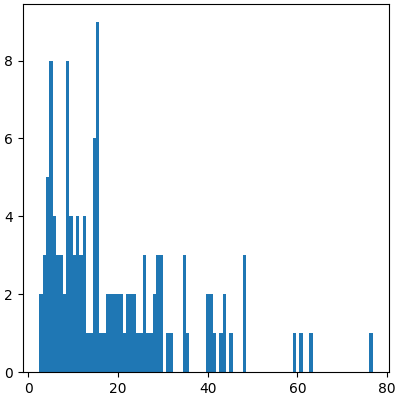

(array([2., 3., 5., 8., 4., 3., 3., 2., 8., 4., 3., 4., 3., 4., 1., 1., 6.,
        9., 1., 1., 2., 2., 2., 2., 2., 1., 2., 2., 2., 1., 1., 3., 1., 1.,
        2., 3., 3., 0., 1., 1., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 2.,
        2., 1., 0., 1., 2., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 2.49668898,  3.23946859,  3.98224821,  4.72502782,  5.46780744,
         6.21058705,  6.95336667,  7.69614628,  8.4389259 ,  9.18170551,
         9.92448513, 10.66726475, 11.41004436, 12.15282398, 12.89560359,
        13.63838321, 14.38116282, 15.12394244, 15.86672205, 16.60950167,
        17.35228129, 18.0950609 , 18.83784052, 19.58062013, 20.32339975,
        21.06617936, 21.80895898, 22.55173859, 23.29451821, 24.03729782,
        24.78007744, 25.52285706, 26.26563667, 27.00841629, 27.7511959 ,
        28.49397552, 29.23675513, 29.97

In [16]:
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)

ax.hist(EEG_metrics['first_peak_amp'].values, bins=100)

## Plot some metrics

<IPython.core.display.Javascript object>


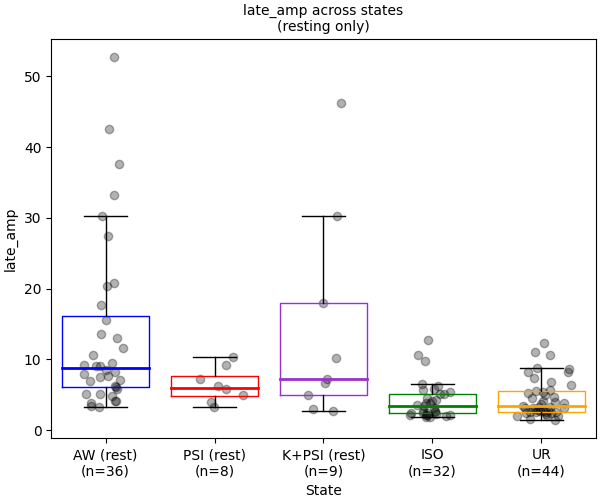

In [20]:
pmetric = 'late_amp' # 'PCIst' 'response_magnitude' 'response_duration' 'early_amp'
pstates = ['awake', 'psilocybin', 'ketanserin', 'isoflurane', 'urethane']

st_labels = ['AW (rest)', 'PSI (rest)', 'K+PSI (rest)', 'ISO', 'UR']
st_colors = ['blue', 'red', 'darkorchid', 'green', 'orange']

fig, ax = plt.subplots(figsize=(6,5), constrained_layout=True)
xlabels = []
for ii, statei in enumerate(pstates):
    statedf = EEG_metrics[EEG_metrics['state'] == statei]
    xs = np.random.normal(ii, 0.1, len(statedf)) # np.zeros(len(statedf)) + ii
    ax.boxplot(
        statedf[pmetric].values, positions=[ii], widths=[0.8], showfliers=False,
        medianprops={'color': st_colors[ii], 'linewidth': 2}, boxprops={'color': st_colors[ii]}
    )
    ax.scatter(xs, statedf[pmetric].values, c='k', marker='o', alpha=0.3)
    xlabels.append('{}\n(n={:d})'.format(st_labels[ii], len(statedf)))
        
ax.set_xticklabels(xlabels)
ax.set_xlabel('State')
ax.set_ylabel(pmetric)
ax.set_title('{} across states\n(resting only)'.format(pmetric))

## Save ##
figname = '{}_allstates_{}.png'.format(pmetric, date.today().strftime('%b%d%Y'))
fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

### Now exclude sets with low first peak amp

In [21]:
chosen_EP_metrics = EEG_metrics[EEG_metrics['first_peak_amp'] > 10.0]

<IPython.core.display.Javascript object>


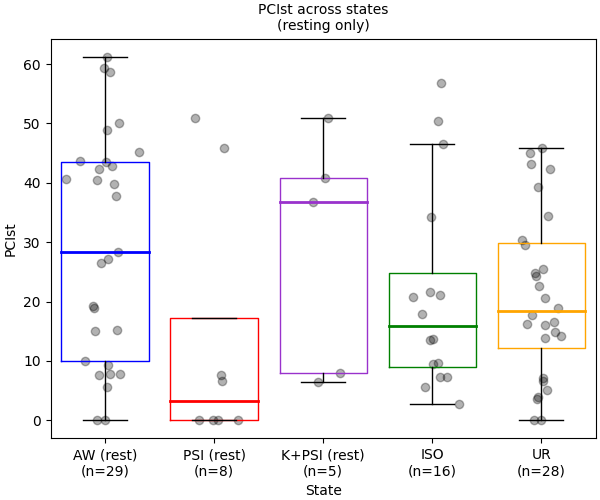

In [22]:
pmetric = 'PCIst' # 'PCIst' 'response_magnitude' 'response_duration'
pstates = ['awake', 'psilocybin', 'ketanserin', 'isoflurane', 'urethane']

st_labels = ['AW (rest)', 'PSI (rest)', 'K+PSI (rest)', 'ISO', 'UR']
st_colors = ['blue', 'red', 'darkorchid', 'green', 'orange']

fig, ax = plt.subplots(figsize=(6,5), constrained_layout=True)
xlabels = []
for ii, statei in enumerate(pstates):
    statedf = chosen_EP_metrics[chosen_EP_metrics['state'] == statei]
    xs = np.random.normal(ii, 0.1, len(statedf)) # np.zeros(len(statedf)) + ii
    ax.boxplot(
        statedf[pmetric].values, positions=[ii], widths=[0.8], showfliers=False,
        medianprops={'color': st_colors[ii], 'linewidth': 2}, boxprops={'color': st_colors[ii]}
    )
    ax.scatter(xs, statedf[pmetric].values, c='k', marker='o', alpha=0.3)
    xlabels.append('{}\n(n={:d})'.format(st_labels[ii], len(statedf)))
        
ax.set_xticklabels(xlabels)
ax.set_xlabel('State')
ax.set_ylabel(pmetric)
ax.set_title('{} across states\n(resting only)'.format(pmetric))

## Save ##
figname = '{}_allstates_high10peak_{}.png'.format(pmetric, date.today().strftime('%b%d%Y'))
fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

#### Plot some EPs

In [39]:
expdict['EEG_traces']['awake'].keys()

dict_keys(['high'])

<IPython.core.display.Javascript object>


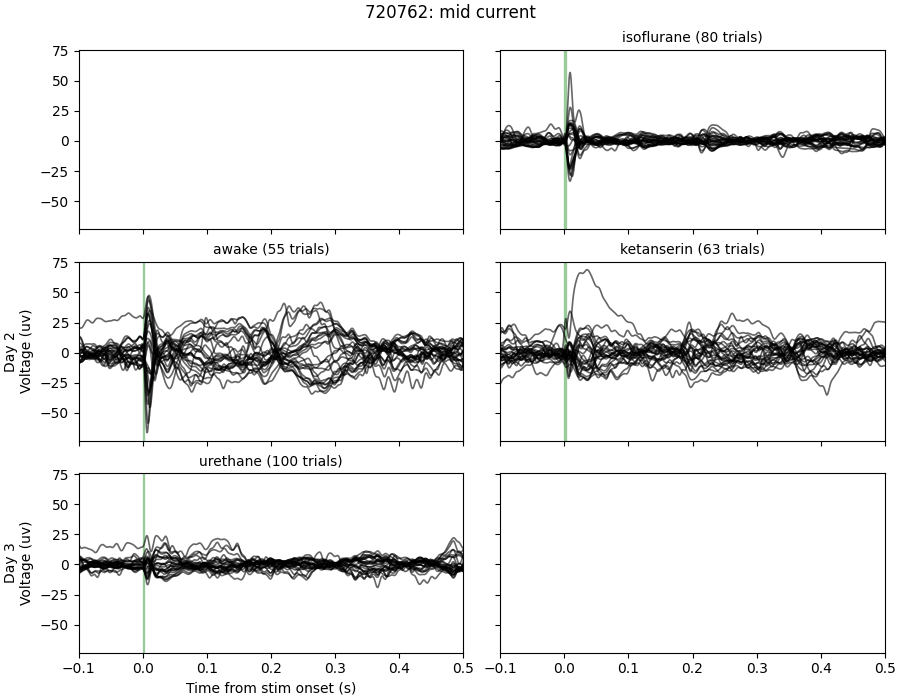

In [23]:
subsub = '720762'
pcurr = 'mid'
plot_window = [-0.1, 0.5]

exp_num = len(all_info[subsub])
fig, axs = plt.subplots(exp_num, 2, figsize=(9, 7), constrained_layout=True, sharex=True, sharey=True)

for rowi, (expday, expdict) in enumerate(all_info[subsub].items()):
    good_chs = expdict['info']['good_chs']
    for coli, (statei, stdict) in enumerate(expdict['EEG_traces'].items()):
        if pcurr not in stdict.keys():
            continue
        timex = stdict[pcurr][0]
        ep = np.mean(stdict[pcurr][1], axis=2)

        axs[rowi,coli].axvspan(0, 0.002, color='g', alpha=0.3)
        axs[rowi,coli].plot(timex, ep[:, good_chs], 'k', linewidth=1.2, alpha=0.6)
        axs[rowi,coli].set_title('{} ({:d} trials)'.format(statei, stdict[pcurr][1].shape[2]))
        
        if coli == 0:
            axs[rowi,coli].set_ylabel('Day {:d}\nVoltage (uv)'.format(rowi+1))

        
axs[rowi,coli].set_xlim(plot_window)
axs[rowi,coli].set_xlabel('Time from stim onset (s)')

fig.suptitle('{}: {} current'.format(subsub, pcurr))

## Save ##
figname = '{}_{}_EPs_goodresttrials.png'.format(subsub, pcurr)
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

# EP metrics

In [54]:
PCI_params = {
    'baseline_window': (-0.8, -0.002), # s before stim for baseline, my default: (-0.5, -0.001)
    'response_window': (0.002, 0.8), # s after stim for response, my default: (0.001, 0.5)
    'k': 1.2,
    'min_snr': 1.6, # my default: 1.1
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}
zlim = 3
trial_lim = 5

In [55]:
EEG_sample_rate = 2500.

all_sub_metrics = []
for mousei in all_info.keys():
    print(mousei)
    for expi in all_info[mousei].keys():
        print(' {}'.format(expi))
        good_chs = all_info[mousei][expi]['info']['good_chs']
        for statei in all_info[mousei][expi]['EEG_traces'].keys():
            print('  {}'.format(statei))
            for curri in all_info[mousei][expi]['EEG_traces'][statei].keys():
                
                timex = all_info[mousei][expi]['EEG_traces'][statei][curri][0]
                ep_trials = all_info[mousei][expi]['EEG_traces'][statei][curri][1]
                
                num_trials = ep_trials.shape[2]
                
                if num_trials >= trial_lim:
                    state_avg = np.mean(ep_trials, axis=2)
                    
                    ## Calculate global field power duration ##
                    gfpow = np.std(state_avg[:, good_chs], axis=1)
                    blmean = np.mean(gfpow[timex < 0])
                    blstd = np.std(gfpow[timex < 0])
                    zgfpow = (gfpow - blmean) / blstd
                    response_duration = np.sum(zgfpow[timex > 0] > zlim) / EEG_sample_rate
                    
                    ## Area under global field power curve ##
                    zerp = np.where((zgfpow[timex > 0] - zlim) >= 0, (zgfpow[timex > 0] - zlim), 0.)
                    auc = integrate.simps(zerp, timex[timex > 0], axis=0, even='last')
                    
                    ## Calulate PCIst ##
                    PCIval = calc_PCIst(state_avg[:, good_chs].T, timex, **PCI_params)
                    
                    
                    all_sub_metrics.append([
                        mousei, expi, len(good_chs), statei, curri, num_trials, response_duration, auc, PCIval
                    ])
                    
    print('')
    
EEG_metrics = pd.DataFrame(
    all_sub_metrics,
    columns=['mouse', 'experiment', 'num_good_chs', 'state', 'stim_current', 'num_trials', 'response_duration', 'response_magnitude', 'PCIst']
)

676727
 psilocybin
  awake
  psilocybin
 isoflurane
  awake
  isoflurane
 urethane
  urethane

689239
 isoflurane
  awake
  isoflurane
 urethane
  urethane

689242
 psilocybin
  awake
  psilocybin
 isoflurane
  awake
  isoflurane
 urethane
  urethane

692644
 isoflurane
  awake
  isoflurane
 psilocybin
  awake
  psilocybin
 urethane
  urethane

703064
 isoflurane
  awake
  isoflurane
 psilocybin
  awake
  psilocybin
 urethane
  urethane

703065
 psilocybin
  awake
  psilocybin
 isoflurane
  awake
  isoflurane
 urethane
  urethane

709401
 isoflurane
  awake
  isoflurane
 psilocybin
  awake
  psilocybin
 urethane
  urethane



<IPython.core.display.Javascript object>


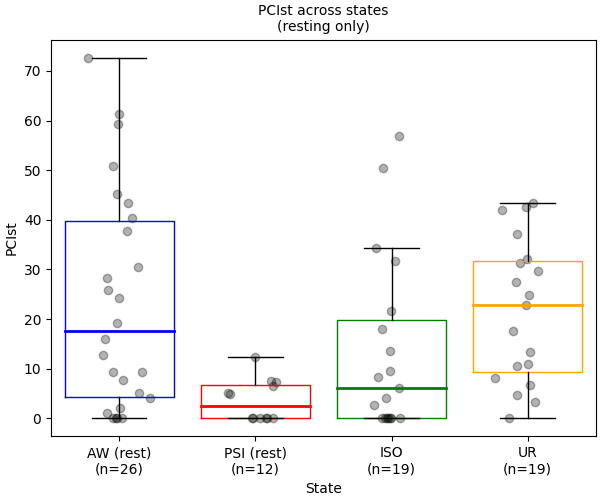

In [66]:
pmetric = 'PCIst' # 'PCIst' 'response_magnitude' 'response_duration'
pstates = ['awake', 'psilocybin', 'isoflurane', 'urethane']

st_labels = ['AW (rest)', 'PSI (rest)', 'ISO', 'UR']
st_colors = ['blue', 'red', 'green', 'orange']

fig, ax = plt.subplots(figsize=(6,5), constrained_layout=True)
xlabels = []
for ii, statei in enumerate(pstates):
    statedf = EEG_metrics[EEG_metrics['state'] == statei]
    xs = np.random.normal(ii, 0.1, len(statedf)) # np.zeros(len(statedf)) + ii
    ax.boxplot(
        statedf[pmetric].values, positions=[ii], widths=[0.8], showfliers=False,
        medianprops={'color': st_colors[ii], 'linewidth': 2}, boxprops={'color': st_colors[ii]}
    )
    ax.scatter(xs, statedf[pmetric].values, c='k', marker='o', alpha=0.3)
    xlabels.append('{}\n(n={:d})'.format(st_labels[ii], len(statedf)))
        
ax.set_xticklabels(xlabels)
ax.set_xlabel('State')
ax.set_ylabel(pmetric)
ax.set_title('{} across states\n(resting only)'.format(pmetric))

## Save ##
figname = '{}_allstates_{}.png'.format(pmetric, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

In [57]:
statedf = EEG_metrics[EEG_metrics['state'] == 'psilocybin']

In [58]:
statedf

,mouse,experiment,num_good_chs,state,stim_current,num_trials,response_duration,response_magnitude,PCIst
31,692644,psilocybin,21,psilocybin,low,34,0.5656,0.605372,7.282105
32,692644,psilocybin,21,psilocybin,mid,37,0.9216,3.381605,4.865764
33,692644,psilocybin,21,psilocybin,high,28,0.0640,0.028475,0.000000
46,703064,psilocybin,29,psilocybin,low,24,0.0000,0.000000,0.000000
47,703064,psilocybin,29,psilocybin,mid,22,0.0152,0.012438,0.000000
48,703064,psilocybin,29,psilocybin,high,30,0.9564,2.306298,6.555489
52,703065,psilocybin,27,psilocybin,low,8,0.0076,0.000763,0.000000
53,703065,psilocybin,27,psilocybin,mid,7,0.1256,0.137785,12.404511
54,703065,psilocybin,27,psilocybin,high,7,0.0592,0.056689,0.000000
70,709401,psilocybin,29,psilocybin,low,22,0.0012,0.000014,5.002807


# Testing noise sources

### Plot individual trials; all trials, one ch (resting/running)

### Plot individual trials; all trials, one ch (good/bad)

### Plot individual trials; one trial, all chs

### Calculating ERP metrics

In [27]:
subject = '666194'
day = 'saline'
stim = 'biphasic'
zlim = 3

good_chs = subjects_data[subject][day]['good_chs']
EEG_sample_rate = subjects_data[subject][day]['exp'].ephys_params['EEG']['sample_rate']

for curri, sweepdict in subjects_data[subject][day]['EEG_traces'][stim].items():
    sweep_info = subjects_data[subject][day]['sweep_info_df'][
        (subjects_data[subject][day]['sweep_info_df']['stim'] == stim) &
        (subjects_data[subject][day]['sweep_info_df']['parameter'] == curri)
    ].copy()
    sweep_metrics = []
    for sweepi, trialdict in sweepdict.items():
        trial_type_info = [sweepi]
        collabels = ['sweep']
        for trialtype, datai in trialdict.items():
            collabels.extend([trialtype + '_trial_count', trialtype + '_duration', trialtype + '_magnitude'])
            num_trials = datai[1].shape[2]
            EEG_time = datai[0]
            EEG_traces = datai[1]
            trial_type_info.append(num_trials)
            if num_trials == 0:
                print('*sweep {:d}: no {} trials*'.format(sweepi, trialtype))
                trial_type_info.extend([np.nan, np.nan])
                continue

            state_traces = np.mean(EEG_traces, axis=2)
            ## Calculate global field power duration ##
            gfpow = np.std(state_traces[:, good_chs], axis=1)
            blmean = np.mean(gfpow[EEG_time < 0])
            blstd = np.std(gfpow[EEG_time < 0])
            zgfpow = (gfpow - blmean) / blstd
            response_duration = np.sum(zgfpow[EEG_time > 0] > zlim) / EEG_sample_rate
            ## Area under global field power curve ##
            zerp = np.where((zgfpow[EEG_time > 0] - zlim) >= 0, (zgfpow[EEG_time > 0] - zlim), 0.)
            auc = integrate.simps(zerp, EEG_time[EEG_time > 0], axis=0, even='last')
            trial_type_info.extend([response_duration, auc])
        sweep_metrics.append(trial_type_info)
    sweep_metrics_df = sweep_info.merge(pd.DataFrame(sweep_metrics, columns=collabels), on='sweep', how='left')

*sweep 1: no resting trials*
*sweep 9: no resting trials*


In [28]:
sweep_metrics_df.head()

,stim,parameter,sweep,sweep_onset,sweep_offset,sweep_time,all_trial_count,all_duration,all_magnitude,resting_trial_count,resting_duration,resting_magnitude,running_trial_count,running_duration,running_magnitude
0,biphasic,40,0,1237.13552,1708.90544,1472.922839,120,0.3864,6.566660,7,0.4692,3.037979,113,0.3488,5.952705
1,biphasic,40,1,2040.76826,2512.53861,2276.555779,120,0.4284,7.720646,0,NaN,NaN,120,0.4284,7.720646
2,biphasic,40,2,2802.29727,3274.06774,3038.084872,120,0.3364,4.854573,10,0.1312,0.479728,110,0.3656,5.321663
3,biphasic,40,3,3631.66392,4103.43434,3865.928553,119,0.2732,4.251281,3,0.1176,0.169967,116,0.2672,3.975655
4,biphasic,40,4,4425.39026,4897.16064,4661.177814,120,0.2612,2.461473,13,0.3464,1.673742,107,0.1868,1.970941


<IPython.core.display.Javascript object>


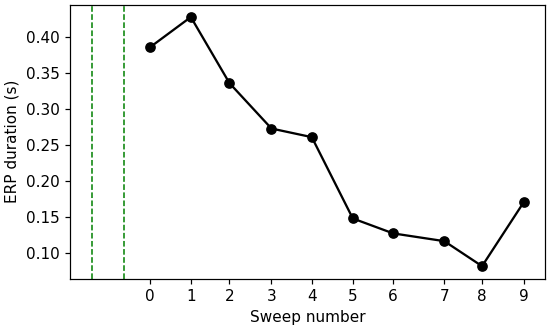

Text(0, 0.5, 'ERP duration (s)')

In [29]:
fig, ax = plt.subplots(figsize=(5, 3), constrained_layout=True)
for inji in subjects_data[subject][day]['inj_times']:
    ax.axvline(inji, color='g', linewidth=1.0, linestyle='dashed')
ax.plot(sweep_metrics_df['sweep_time'].values, sweep_metrics_df['all_duration'].values, color='k', marker='o')
ax.set_xticks(sweep_metrics_df['sweep_time'].values)
ax.set_xticklabels(sweep_metrics_df['sweep'].values)
ax.set_xlabel('Sweep number')
ax.set_ylabel('ERP duration (s)')